In [1]:
%matplotlib inline

In [2]:
import datajoint as dj

In [3]:
dj.__version__

'0.13.dev1'

In [4]:
import datajoint as dj
schema = dj.schema('university')
schema.spawn_missing_classes()

Connecting root@fakeservices.datajoint.io:3306


In [5]:
schema.list_tables()

['course',
 'current_term',
 'department',
 'enroll',
 'grade',
 'letter_grade',
 'section',
 'student',
 'student_major',
 'term']

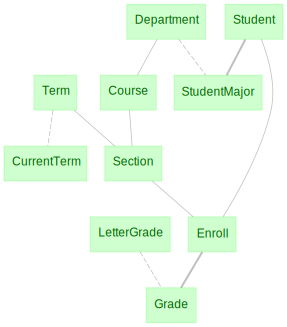

In [6]:
dj.Diagram(schema)

# Example queries

## Restriction

In [16]:
Student.proj(id1='student_id', s1='home_state') * Student.proj(id2='student_id', s2='home_state') & 'id1 < id2' & 's1="NY"' & 's2="UT"'

id1 university-wide ID number,id2 university-wide ID number,s1 US state acronym: e.g. OH,s2 US state acronym: e.g. OH
137,178,NY,UT
137,180,NY,UT
137,196,NY,UT
137,347,NY,UT
137,348,NY,UT
174,178,NY,UT
174,180,NY,UT
174,196,NY,UT
174,347,NY,UT
174,348,NY,UT


In [21]:
(Student.proj() * Student.proj(s2='student_id'))

student_id university-wide ID number,s2 university-wide ID number
100,100
101,100
102,100
103,100
104,100
105,100
106,100
107,100
108,100
109,100


In [7]:
# Students from Texas
Student & {'home_state': 'TX'}
Student & 'home_state="TX"'

student_id university-wide ID number,first_name,last_name,sex,date_of_birth,home_address mailing street address,home_city mailing address,home_state US state acronym: e.g. OH,home_zip zipcode e.g. 93979-4979,home_phone e.g. 414.657.6883x0881
114,Gabriella,Orozco,F,1998-12-07,2316 Amy Lakes,West Rebeccastad,TX,75957,(546)688-9373x467


In [ ]:
# Male students from outside Texas
(Student & 'sex="M"') - {'home_state': 'TX'}

In [ ]:
# Male students from outside Texas
Student & 'sex="M" and home_state <> "TX"'
(Student & {'sex':"M"}) - {'home_state': "TX"}

In [ ]:
# Students from TX, OK, or NM
Student & [{'home_state':'OK'}, {'home_state':'NM'}, {'home_state':'TX'}] 
Student & [{'home_state': s} for s in ('OK','NM','TX')]
Student & 'home_state in ("OK", "NM", "TX")'

In [ ]:
# Millenials
millenials = Student & 'date_of_birth between "1981-01-01" and "1996-12-31"'

In [ ]:
# Millenials
millenials - (Enroll & 'dept="MATH"')

In [ ]:
(millenials - (Enroll & 'dept="MATH"')).make_sql()

In [ ]:
# Students who have taken classes
Student & Enroll

In [ ]:
# Students who have not taken classes
Student - Enroll

In [ ]:
# Students who have taken Biology classes but no MATH courses
(Student & (Enroll & 'dept="BIOL"')) - (Enroll & 'dept="MATH"')

In [ ]:
# Students who have not selected a major
Student - StudentMajor

In [ ]:
# Students who are not taking courses in the current term
Student - (Enroll & CurrentTerm)

In [ ]:
StudentMajor()

In [ ]:
# Ungraded enrollments, including student major
ungraded = Enroll - Grade

ungraded * StudentMajor.proj(..., major='dept')

q = ungraded.join(StudentMajor.proj(..., major='dept'), left=True)

q

In [ ]:
q.make_sql()

In [ ]:
# Ungraded courses in the current term
(Enroll & CurrentTerm) - Grade

In [ ]:
# Students who have taken classes and have chosen a major
(Student & Enroll & StudentMajor).fetch(as_dict=True)

In [ ]:
#Students who are active or major in non-math, or are named Robert
Student & [Enroll, StudentMajor - {'dept': "MATH"}, 'first_name="Robert"'] 

In [ ]:
# Enrollment in courses from the same department as the students' major
Enroll & StudentMajor

In [ ]:
# Enrollments for students with a major
Enroll & StudentMajor.proj(major="dept")

## Join

In [ ]:
# Grade point values
Grade * LetterGrade

In [ ]:
# Graded enrollments with complete course and student information
Student * Enroll * Course * Section * Grade * LetterGrade

In [ ]:
# Students with ungraded courses in current term
Student & (Enroll * CurrentTerm - Grade)

## Proj

In [ ]:
# remove student personal info other than home state and sex
Student.proj('home_state', 'sex')

In [ ]:
# Student major
Student.proj('first_name','last_name')*StudentMajor.proj(..., major='dept')

In [ ]:
# Enrollment with major information
Enroll * StudentMajor.proj(major='dept')

In [ ]:
# Enrollment outside chosen major
Enroll * StudentMajor.proj(major='dept') & 'major<>dept'

In [ ]:
# Enrollment not matching major 
Enroll - StudentMajor 

In [ ]:
# Total grade points
(Course * Grade * LetterGrade).proj(total='points*credits')

## Aggr

In [ ]:
%%timeit
dj.U().aggr(Student(), n='count(*)').fetch1()

In [ ]:
%%timeit
len(Student())

In [ ]:
# Students in each section
Section.aggr(Enroll, ..., n='count(student_id)', keep_all_rows=True)

In [ ]:
# Students in each section of the biology department
(Section & {"dept": "BIOL"}).aggr(Enroll, n='count(student_id)', keep_all_rows=True) & 'n=0' 

In [ ]:
# Average grade in each course
Course.aggr(Grade*LetterGrade, avg_grade='round(avg(points), 2)')

In [ ]:
# Fraction graded in each section
(Section.aggr(Enroll, n='count(student_id)') * Section.aggr(Grade, m='count(student_id)')).proj(
    percent_graded='100*round(m/n, 2)')

In [ ]:
Course * Grade * LetterGrade

In [ ]:
# GPA
Student.aggr(Course * Grade * LetterGrade, 
             gpa='round(sum(points*credits)/sum(credits), 2)')

In [ ]:
Student.aggr(Course * Grade * LetterGrade, 
             gpa='round(sum(points*credits)/sum(credits), 2)').make_sql()

In [ ]:
# GPA in current Term
Student.aggr(Course * Grade * LetterGrade & CurrentTerm, 
             gpa='round(sum(points*credits)/sum(credits), 2)')

In [ ]:
# Average GPA for each major
gpa = Student.aggr(Course * Grade * LetterGrade,
                   gpa='sum(points*credits)/sum(credits)')
Department.aggr(StudentMajor*gpa, avg_gpa='round(avg(gpa), 2)')

## Universal sets dj.U()

In [ ]:
# The number of students from each state
dj.U('home_state').aggr(Student, n='count(*)')

In [ ]:
# Unique last names
dj.U('last_name') & Student 

In [ ]:
# Number of students from each state by gender
dj.U('home_state', 'sex').aggr(Student, n='count(*)')

In [ ]:
# GPA by sex
dj.U('sex').aggr(Student*gpa, avg_gpa ='avg(gpa)')

In [ ]:
# Sex ratio for gender neutral names
(dj.U('first_name').aggr(Student, percent_male='100*avg(sex="M")'
                       ) & 'percent_male > 0 and percent_male < 100')

# New operators in version 0.13

* Permissive join:  `a @ b`  is equivalent to `a.join(b, semantic_check=False)`.
* Permissive restrict: `a ^ b` is equivalent to `a.restrict(b, semantic_check=False)`.
* Uninary minus: `a & -b` is equivalent to `a - b` or `a & dj.Not(b)`.

In [ ]:
# Students with the same birthdays
s1 = Student.proj('date_of_birth', s1='student_id')
s2 = Student.proj('date_of_birth', s2='student_id')
s1 @ s2 & 's1 < s2'

In [ ]:
# Students with other students born on the same date
s1 = Student.proj('date_of_birth', s1='student_id')
s2 = Student.proj('date_of_birth', s2='student_id')
s1 ^ (s1 @ s2 & 's1 < s2')

In [ ]:
# Students with unique birthdays
s1 -(s1 @ s2 & 's1 < s2')  # error because minus is not permissive
s1 ^ dj.Not(s1 @ s2 & 's1 < s2')
s1 ^ -(s1 @ s2 & 's1 < s2')